# Iodine Spectrometer Data Collection

Enter run label (e.g. 'reference_lamp' or 'iodine_sample'): Slit - 3 mm
Enter START wavelength from spectrometer display (nm): 620.1
5
4
3
2
1
Starting now!
Activated Channel 0
Acquisition started — press ENTER to stop.

Press ENTER to stop acquisition...

Enter END wavelength from spectrometer display (nm): 642.2
Points: 1227 | Duration: 12.27 s | Start λ: 620.1 nm | End λ: 642.2 nm


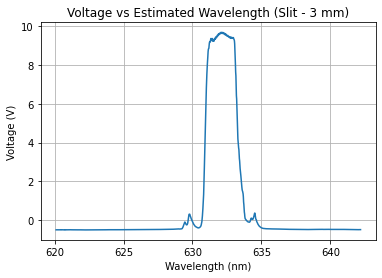

In [33]:
import time
from threading import Event, Thread
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydaqmx_helper.adc import ADC  


sample_rate = 10000
samples_num = 100

def _wait_for_enter(stop_event: Event):
    input("Press ENTER to stop acquisition...\n")
    stop_event.set()

def acquire_channel0_simple(sample_rate, samples_num):

    for s in range(5, 0, -1):
        print(s)
        time.sleep(1)
    print("Starting now!")

    myADC = ADC()
    myADC.addChannels([0], minRange=-10, maxRange=10)

    stop_event = Event()
    stopper = Thread(target=_wait_for_enter, args=(stop_event,), daemon=True)
    stopper.start()

    # Running lists
    time_stamps_sec = []
    averaged_voltages = []
    voltage_stds = []

    total_samples_read = 0
    print("Acquisition started — press ENTER to stop.\n")

    while not stop_event.is_set():

        block = np.asarray(myADC.sampleVoltages(samples_num, sample_rate)[0], dtype=float).reshape(-1)

        block_mean = float(block.mean())
        block_std  = float(block.std(ddof=1)) if block.size > 1 else 0.0

        mid_sample_index = total_samples_read + (samples_num / 2.0)
        mid_time_s = mid_sample_index / sample_rate

        time_stamps_sec.append(mid_time_s)
        averaged_voltages.append(block_mean)
        voltage_stds.append(block_std)

        total_samples_read += block.size

    df = pd.DataFrame({
        "time": np.array(time_stamps_sec),
        "mean_v": np.array(averaged_voltages),
        "std_v": np.array(voltage_stds),
    })
    return df

run_label = input("Enter run label (e.g. 'reference_lamp' or 'iodine_sample'): ").strip() or "run"
lambda_start_nm = float(input("Enter START wavelength from spectrometer display (nm): ").strip())

df = acquire_channel0_simple(sample_rate, samples_num)

elapsed_s = df["time"].iloc[-1] + (samples_num / sample_rate) / 2.0 if len(df) else 0.0
lambda_end_nm = float(input("Enter END wavelength from spectrometer display (nm): ").strip())

if elapsed_s > 0:
    df["wavelength"] = lambda_start_nm + (lambda_end_nm - lambda_start_nm) * (df["time"] / elapsed_s)
else:
    df["wavelength"] = np.nan

pd.DataFrame.to_csv(df, Path(f"ADC_{run_label}.csv"), index=False)

print(f"Points: {len(df)} | Duration: {elapsed_s:.2f} s | Start λ: {lambda_start_nm} nm | End λ: {lambda_end_nm} nm")

wavelengths = np.array(df["wavelength"])
voltages = np.array(df["mean_v"])

plt.plot(wavelengths, voltages)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Voltage (V)")
plt.title(f"Voltage vs Estimated Wavelength ({run_label})")
plt.grid(True)

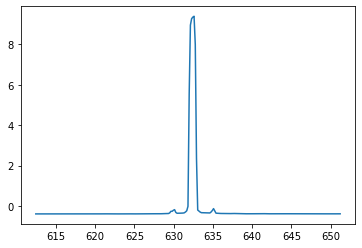

In [18]:
file = pd.read_csv('ADC_Laser - Trial one.csv')
angle = list(file['lambda_nm_est'])
volts = list(file['ch0_mean_V'])

plt.plot(angle[400:], volts[400:])
#plt.xlim(630,635)

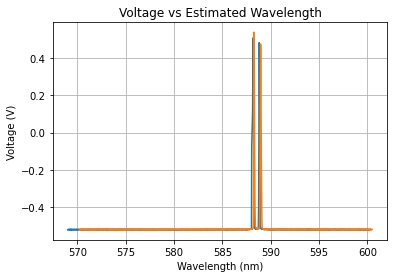

In [21]:
file = pd.read_csv('ADC_ADC_Sodium lamp (slit = 0.1) - 570 - 600 - motor 2.0 V.csv')
file2 = pd.read_csv('ADC_ADC_Sodium lamp (slit = 0.1) - 570 - 600 - Trial 2ADC_Sodium lamp (slit = 0.1) - 570 - 600 - Trial 3.csv')

wavelengths = np.array(file['wavelength'])
voltages = np.array(file['mean_v'])

wavelengths2 = list(file2['wavelength'])
voltages2 = list(file2['mean_v'])

plt.plot(wavelengths,voltages)
plt.plot(wavelengths2,voltages2)
plt.xlabel("Wavelength (nm)")  
plt.ylabel("Voltage (V)")
plt.xlim(570, 570.5)
plt.title(f"Voltage vs Estimated Wavelength")
plt.grid(True)

*Testing for different slit widths:* 0.1, 0.2, 0.3, 0.5, 0.69, 0.8, 1, .5, 2, 2.5 , 3 nm

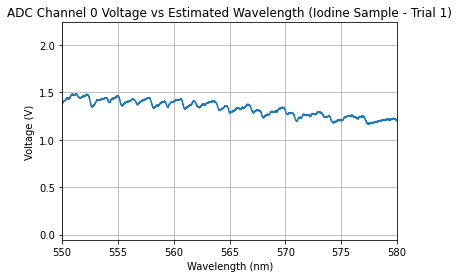

In [16]:
wavelengths = np.array(df["wavelength"])
voltages = np.array(df["mean_v"])

plt.plot(wavelengths, voltages)
plt.xlabel("Wavelength (nm)")
plt.xlim(550,580)
plt.ylabel("Voltage (V)")
plt.title(f"ADC Channel 0 Voltage vs Estimated Wavelength ({run_label})")
plt.grid(True)